# Transfer Learning with TensorFlow - Part 2: Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning.

In [2]:
# Check if we're using a GPU
!nvidia-smi

Sun Aug 28 14:25:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

IN the previous notebooks, we're created a bunch of helper functions. Now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).


We're done this for some of the functions we're used previously here:

https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-28 14:25:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-28 14:25:56 (61.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import hepler functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

🔑 **Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_functions.py`, so you'll have to redownload it if you want access to your helper functions.

## Let's get some data

This time we're going to see how we can use the pretrained models wthin `tf.keras,applications` and apply them to our own problem (recognizing images of food).

Link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [5]:
# Get 10% of training data of 10 classes of Food101

! wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-08-28 14:25:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.128, 173.194.202.128, 74.125.199.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   139MB/s    in 1.2s    

2022-08-28 14:26:00 (139 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [7]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [8]:
import tensorflow as tf 

In [9]:
IMG_SIZE=(224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode = "categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [10]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [11]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [12]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.07801018e+02 8.18010178e+01 4.68010178e+01]
   [9.99285660e+01 7.48571396e+01 4.37142830e+01]
   [7.08622437e+01 4.99336700e+01 2.80051022e+01]
   ...
   [8.00000000e+00 8.00000000e+00 6.00000000e+00]
   [8.07144165e+00 8.07144165e+00 6.07144165e+00]
   [1.00000000e+01 1.00000000e+01 8.00000000e+00]]

  [[1.09091835e+02 8.30918350e+01 4.80918388e+01]
   [9.66428528e+01 7.15714264e+01 4.04285698e+01]
   [7.37857056e+01 5.28571434e+01 3.09285698e+01]
   ...
   [8.19895935e+00 8.19895935e+00 6.19895935e+00]
   [9.06633854e+00 9.06633854e+00 7.06633854e+00]
   [1.03571777e+01 1.03571777e+01 8.35717773e+00]]

  [[1.09280609e+02 8.32806091e+01 4.82806129e+01]
   [9.83010254e+01 7.34285660e+01 4.16581650e+01]
   [7.60969315e+01 5.51683655e+01 3.23622437e+01]
   ...
   [9.00000000e+00 9.00000000e+00 7.00000000e+00]
   [9.27041817e+00 9.27041817e+00 7.27041864e+00]
   [1.10765381e+01 1.10765381e+01 9.07653809e+00]]

  ...

  [[2.23224014e+02 2.08438171e+02 1.68223846e+02]
   [2

## Model 0:Building a transfer learning feature extraction model using the Keras Functional API

The Sequential API is straight-forward, it runs our layers in sequential order.

Yet the functional API gives us more flexibility with our models.

In [13]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNet)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10.  Fit the model
history_10_percent = model_0.fit(train_data_10_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="10_percent_feature_extraction_model_0")])

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction_model_0/20220828-142608
Epoch 1/5
24/24 [==============================] - 23s 265ms/step - loss: 1.9431 - accuracy: 0.3933 - val_loss: 1.3846 - val_accuracy: 0.6924
Epoch 2/5
24/24 [==============================] - 5s 186ms/step - loss: 1.1672 - accuracy: 0.7400 - val_loss: 0.9439 - val_accuracy: 0.8043
Epoch 3/5
24/24 [==============================] - 4s 149ms/step - loss: 0.8494 - accuracy: 0.7973 - val_loss: 0.7766 - val_accuracy: 0.8010
Epoch 4/5
24/24 [==============================] - 5s 184ms/step - loss: 0.6950 - accuracy: 0.8413 - val_loss: 0.6581 - val_accuracy: 0.8191
Epoch 5/5
24/24 [==============================] - 5s 185ms/step - loss: 0.6000 - accuracy: 0.8613 - val_loss: 0.6386 - val_accuracy: 0.8207


In [14]:
# Evaluate on the full dataset
model_0.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.6122 - accuracy: 0.8384


[0.612238883972168, 0.8384000062942505]

In [15]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [16]:
# Get a summary of the base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [17]:
# Summary of our whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


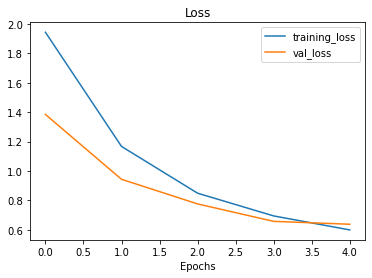

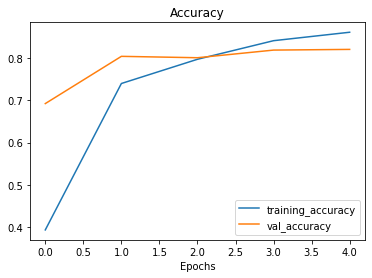

In [18]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer ...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through `GlobalAveragePooling2D`, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4,4,3) and then pass it to `GlobalAveragePooling2D`. 

In [20]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]



In [21]:
# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]



In [22]:
# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}\n")
print(f"Shape of Global Average Pooled 2D tenosr: {global_average_pooled_tensor.shape}")

Shape of input tensor: (1, 4, 4, 3)

Shape of Global Average Pooled 2D tenosr: (1, 3)


In [23]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

⛏ **Practice:** Do the same with the above cells, but this time use `GlobalMaxPool2D` ... & compare the results

In [25]:
# Pass the random tensor through a global max poolin 2D layer
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f"2D Global Max Pooled Random tensor:\n {global_max_pooled_tensor}")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")
print(f"Shape of Global Max Pooled 2D tensor: {global_max_pooled_tensor.shape}")

2D Global Max Pooled Random tensor:
 [[0.9058464 1.1603122 1.6994323]]
Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)
Shape of Global Max Pooled 2D tensor: (1, 3)


🔑 **Note:** One of the reasons feature extraction transfer learning is named how it is because what often happens is pretrained model outputs a **feature vector** (a long tensor of numbers which reprsents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can then be used to extract patterns out of for our own specific problem.